# Visual Transformer with Linformer

Training Visual Transformer on *Covid-3D Data*

* Covid vs. nonCovid Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Effecient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

In [1]:
!pip -q install vit_pytorch linformer

## Import Libraries

In [2]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import torchvision.transforms.functional as TF
from torch.autograd import Variable
import torch.nn.functional as F
import io
import nibabel  # to read .hdr/.img files
import numpy

#from vit_pytorch.efficient import ViT
#from vit_pytorch import ViT
from vit_pytorch import ViT3

def resize2d(img, size):
    return F.adaptive_avg_pool2d(Variable(img),size).data


In [3]:
print(f"Torch: {torch.__version__}")

Torch: 1.8.1+cu102


In [4]:
# Training settings
batch_size = 4 # 64
epochs = 40 #10 #50 #20
lr = 3e-5
gamma = 0.7
seed = 42 # 42

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [6]:
device = 'cuda'

## Load Data

In [7]:
os.makedirs('data-3d', exist_ok=True)

In [8]:
train_dir = 'data-3d/train-3d-32'
test_dir = 'data-3d/test-3d-32'

In [9]:
#with zipfile.ZipFile('train-3d.zip') as train_zip:
    #train_zip.extractall('data-3d')
    
#with zipfile.ZipFile('test-3d.zip') as test_zip:
    #test_zip.extractall('data-3d')

In [10]:
train_list = glob.glob(os.path.join(train_dir,'*.hdr'))
test_list = glob.glob(os.path.join(test_dir, '*.hdr'))

In [11]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 3773
Test Data: 722


In [12]:
labels = [path.split('/')[-1].split('_')[0] for path in train_list]

## Random Plots

ran-idx-list = [103 436 271 107  72 701  21 615 122]


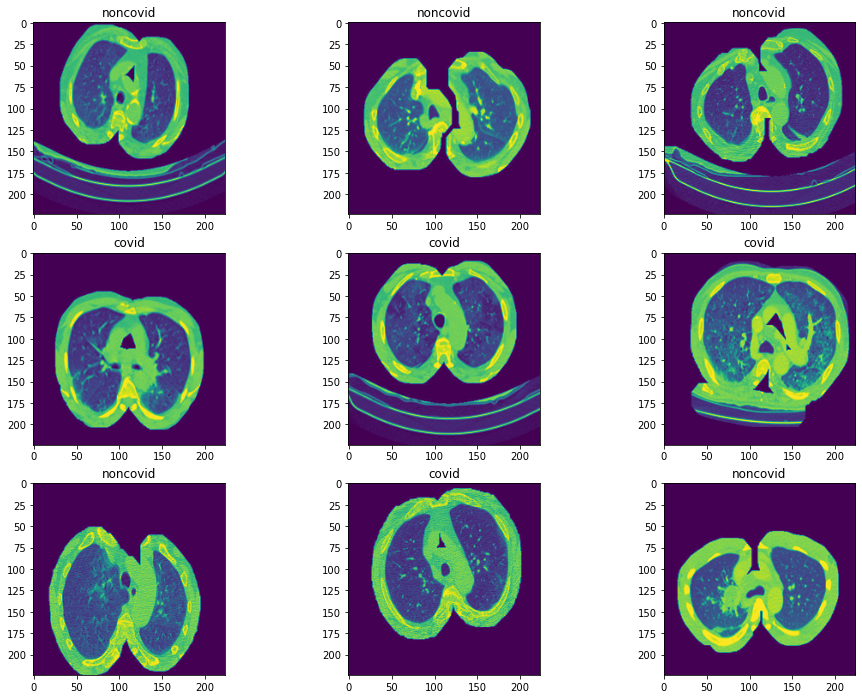

In [13]:
#random_idx = np.random.randint(1, len(train_list), size=9)
random_idx = np.random.randint(1, len(test_list), size=9)
print('ran-idx-list =', random_idx)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    #img = Image.open(train_list[idx])
    img = nibabel.load(train_list[idx])
    img = numpy.asanyarray(img.dataobj) #struct.get_data()
    img = numpy.rot90(img)
    #print('img-shape=',img)
    ax.set_title(labels[idx])
    ax.imshow(img[:,:,1])


## Split

In [14]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [15]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 3018
Validation Data: 755
Test Data: 722


## Image Augumentation

In [16]:

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


## Load Datasets

In [17]:
class CovidDataset_3D(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        #img = Image.open(img_path)
        img = nibabel.load(img_path)
        img = numpy.asanyarray(img.dataobj)  #struct.get_data()
        #!vimg = numpy.rot90(img)     # convert image back to the right coordination
        #print('3d-img-shape', img.size,type(img), img.shape, img[:,:,0,0].shape)
        img2 = torch.tensor(np.array(img))
        img_transformed=img2.permute(3,2,0,1)
        #x = torch.zeros[1,16,224,224]
        #for i in range(16):
            #img1 = img[:,:,i,0]
            #img_transformed.append(img)
        
        #img_transformed = torch.tensor(img_transformed.copy())
        #print('3d-img-shape-trans=',type(img_transformed), img_transformed.shape)
        label = img_path.split("/")[-1].split("_")[0]    
        label = 1 if label == "covid" else 0
        #print('img,label=',img_path, label)
        return img_transformed, label


In [18]:
train_data = CovidDataset_3D(train_list, transform=None)
valid_data = CovidDataset_3D(valid_list, transform=None)
test_data = CovidDataset_3D(test_list, transform=None)

In [19]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [20]:
print(len(train_data), len(train_loader))
a = train_data[0]
#aa = torch.from_numpy(a.values)
print('train-data-shape=',a[0].shape, a[1], type(a))
#print('tuple2torch=', torch.stack(list(a), dim=0))

3018 755
train-data-shape= torch.Size([1, 32, 224, 224]) 1 <class 'tuple'>


In [21]:
print(len(valid_data), len(valid_loader))
print(len(test_data), len(test_loader))

755 189
722 181


## Effecient Attention

### Linformer

In [22]:
efficient_transformer = Linformer(
    dim=1024,
    seq_len=512+1,  # 8x8x8+1 for 3D# 7x7 patches + 1 cls-token
    depth=6,
    heads=8,
    k=256   # was 64
)

### Visual Transformer

In [23]:
model = ViT3(
    dim=1024,
    image_size=224,
    patch_size=8, 
    num_classes=2,
    depth=6,
    heads=8,
    mlp_dim=2048,
    transformer=efficient_transformer,
    channels=1
).to(device)
# load pre-trained model
pretrained_net = torch.load('xg_vit_model_covid_3D.pt')
model.load_state_dict(pretrained_net)

xg:n_patches,p-dim, mlp_dim,depth= 3136 512 2048 6
dim, mlp_dim= 1024 2048
self-pos,patch2-embedding,cls_tokem,dropput torch.Size([3137, 1024]) Linear(in_features=512, out_features=1024, bias=True) torch.Size([1, 1024]) Dropout(p=0.0, inplace=False)
ViT:dim,mlp_dim= 1024 2048
transformer:,input= 1024 6 8 256 2048
dim,hidden_din= 1024 2048
dim,hidden_din= 1024 2048
dim,hidden_din= 1024 2048
dim,hidden_din= 1024 2048
dim,hidden_din= 1024 2048
dim,hidden_din= 1024 2048
2:ViT:dim,mlp_dim= 1024 2048


<All keys matched successfully>

### Training

In [24]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
       # print('data,label =', data.shape, len(label))
        
        output = model(data.float())
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        # save a checkpoint

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data.float()) 
            #print('val-data, max=',val_output.data[0], torch.max(val_output.data[0],0))
            val_loss = criterion(val_output, label)
            # print the resulrs
            cls = torch.max(val_output[0],0)
            cls = cls.indices
            #print('val-output',cls)
            
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    torch.save(model.state_dict(),'xg_vit_model_covid_3D.pt')   #xg

    # saving the data
with io.open('3d32-val-output.txt', 'w') as f:
    for i in range(len(label)):
        if cls>0:
            f.write("%s %s\n" % ('1', int(label[i].data)))
        else:
            f.write("%s %s\n" % ('0', int(label[i].data)))



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6947 - acc: 0.4957 - val_loss : 0.6930 - val_acc: 0.5084



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6947 - acc: 0.4881 - val_loss : 0.6930 - val_acc: 0.5084



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6948 - acc: 0.5003 - val_loss : 0.6942 - val_acc: 0.5088



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6941 - acc: 0.5060 - val_loss : 0.6931 - val_acc: 0.5088



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6951 - acc: 0.4868 - val_loss : 0.6934 - val_acc: 0.5093



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6944 - acc: 0.5146 - val_loss : 0.6936 - val_acc: 0.4912



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6947 - acc: 0.4924 - val_loss : 0.6935 - val_acc: 0.4907



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6949 - acc: 0.4954 - val_loss : 0.6930 - val_acc: 0.5093



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6945 - acc: 0.5010 - val_loss : 0.6966 - val_acc: 0.4921



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6949 - acc: 0.4874 - val_loss : 0.6934 - val_acc: 0.5093



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6941 - acc: 0.5056 - val_loss : 0.6971 - val_acc: 0.5084



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6946 - acc: 0.5023 - val_loss : 0.6949 - val_acc: 0.4907



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6945 - acc: 0.4954 - val_loss : 0.6933 - val_acc: 0.4916



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6942 - acc: 0.5030 - val_loss : 0.6958 - val_acc: 0.4907



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6935 - acc: 0.5126 - val_loss : 0.6965 - val_acc: 0.5079



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6957 - acc: 0.4967 - val_loss : 0.6935 - val_acc: 0.4907



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6941 - acc: 0.5023 - val_loss : 0.6932 - val_acc: 0.5088



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6948 - acc: 0.4973 - val_loss : 0.6930 - val_acc: 0.5084



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.6936 - acc: 0.5053 - val_loss : 0.6957 - val_acc: 0.4912



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.6945 - acc: 0.4904 - val_loss : 0.6934 - val_acc: 0.5079



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.6943 - acc: 0.4940 - val_loss : 0.6931 - val_acc: 0.5088



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.6950 - acc: 0.4957 - val_loss : 0.6941 - val_acc: 0.5093



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.6942 - acc: 0.4930 - val_loss : 0.6937 - val_acc: 0.4912



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.6942 - acc: 0.4950 - val_loss : 0.6930 - val_acc: 0.5079



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.6947 - acc: 0.4957 - val_loss : 0.6930 - val_acc: 0.5079



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.6939 - acc: 0.4904 - val_loss : 0.6972 - val_acc: 0.5084



  0%|          | 0/755 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.6941 - acc: 0.5070 - val_loss : 0.6930 - val_acc: 0.5088



  0%|          | 0/755 [00:00<?, ?it/s]

In [ ]:
#Testing
## Loadingn Newly trained model 
model = ViT3(
    dim=1024,
    image_size=224,
    patch_size=8, 
    num_classes=2,
    depth=6,
    heads=8,
    mlp_dim=2048,
    transformer=efficient_transformer,
    channels=1
).to(device)
pretrained_net = torch.load('xg_vit_model_covid_3D.pt')
model.load_state_dict(pretrained_net)

with torch.no_grad():
    for data, label in test_loader:
        data = data.to(device)
        #label = label.to(device)
        test_output = model(data.float()) 
        #print('class=',torch.max(test_output[0],0))
        cls = torch.max(test_output[0],0)
        cls = cls.indices 
# saving the data
        with io.open('3d32-test-output.txt', 'a') as f:
            for i in range(len(data)):
                if cls>0:
                    f.write("%s %s\n" % (test_list[i],'1'))
                else:
                    f.write("%s %s\n" % (test_list[i],'0'))
    
#Working on test data
random_idx = np.random.randint(1, len(test_list),size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
x = torch.zeros(1,1,32,224,224)
for idx, ax in enumerate(axes.ravel()):
    #img = Image.open(test_list[idx])
    print('test-imgpath=',test_list[idx] )
    img = nibabel.load(test_list[idx])
    img = numpy.asanyarray(img.dataobj)  #struct.get_data()
    img1 = img[:,:,:,0]
    img11 = numpy.rot90(img1)
    #img = Image.open(train_list[idx])
    #ax.set_title(labels[idx])
    #print('img1-shape=',img1.shape)
    ax.imshow(img11[:,:,1])
    img2 = torch.tensor(np.array(img))
    #print('img2=', img2.shape)
    img2 = img2.permute(3,2,0,1)  
    x[0]=img2
    #print('x[0][0]=', x.size())
    #print('img-name=,', test_list[idx])
    #print('img1=',img1.shape)
    #img2 = TF.to_tensor(img1)
    #print('img2-shape=',img2.shape)
    #img2 = resize2d(img1,(224,224))
    #x = torch.zeros(1,3,224,224)
    #x[0] = img2
    out = img2.float()
    out.unsqueeze_(0)
    out = out.to('cuda:0')
    model.to('cuda:0')
    # out.to(device)
    preds = model(out)
    print('class=',torch.max(preds[0],0))
    cls = torch.max(preds[0],0)
    cls = cls.indices
    if cls>0:
        labels[idx] = 'Covid'
    else:
        labels[idx] = 'nonCovid'
    with io.open('3d32-test-output-9.txt', 'a') as f:
        f.write("%s %s\n" % (test_list[idx], labels[idx]))
    ax.set_title(labels[idx])